In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gc
from captum.attr import *
import quantus
import gc
import torchvision.transforms as transforms
import os
import torch.optim as optim
import torchvision.models as models
import sklearn
from sklearn.metrics import roc_auc_score

In [107]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [108]:
import warnings
warnings.filterwarnings('ignore')

In [109]:
class Network(nn.Module):
    ''' A basic neural network model '''
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()         #python2 : super(MLP, self).__init__()
        #defining the network's operations
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x, softmax=False): 
        x = x.reshape(-1,47)
        a = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.float())))))
        if softmax:
            y_pred = F.softmax(a, dim=1)
        else:
            y_pred = a
        #print(y_pred.shape)
        return y_pred

In [110]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on : {}".format(device))

Training on : cuda


In [111]:
input_size = 47
hidden_size=[64,64]
output_size=2
model = Network(input_size, hidden_size, output_size)
model

Network(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [112]:
model.to(device)

Network(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [113]:
df = pd.read_csv('clean_examples.csv')
df.head()

,Unnamed: 0,Destination Port,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Class
0,0,80.0,0.000000,0.00000,0.0000,0.0000,0.000000,4000.000000,3.333333e+02,1.753777e+02,...,0.0,251.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,1.0
1,1,80.0,54.666668,133.90544,2898.7500,4095.5662,119.999920,0.100646,1.100000e+07,3.310000e+07,...,11595.0,251.0,235.0,1.0,32.0,4.0,0.0,4.0,4.0,1.0
2,2,80.0,115.666664,173.50000,1656.4286,1547.7377,125.453190,0.158852,6.714855e+06,2.580000e+07,...,11595.0,274.0,235.0,3.0,32.0,1003.0,0.0,1003.0,1003.0,1.0
3,3,80.0,6.000000,0.00000,0.0000,0.0000,8.818477,1.469746,8.504870e+05,1.697628e+06,...,0.0,256.0,-1.0,4.0,20.0,0.0,0.0,0.0,0.0,1.0
4,4,80.0,100.000000,173.20508,1932.5000,1977.8129,83350.850000,63.064957,1.783875e+04,4.638334e+04,...,11595.0,29200.0,235.0,1.0,32.0,0.0,0.0,0.0,0.0,1.0


In [114]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.drop(self.data.columns[0], axis=1)  # Remove unnecessary index column
        self.features = self.data.iloc[:, :-1].values  # Features (all columns except the last)
        self.labels = self.data.iloc[:, -1].values     # Labels (last column)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Load CSV file and split into train and test sets
dataset = CustomDataset('clean_examples.csv')
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [115]:
def make_noise(x_batch, y_batch, spread):
    new_x_batch = []
    for x in x_batch:
        x = x.data.cpu().numpy()
        stdev = spread * (np.max(x)-np.min(x))
        #print(stdev)
        noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
        x_plus_noise = x + noise
        x_plus_noise = np.clip(x_plus_noise, 0, 1)
        x_plus_noise = torch.from_numpy(x_plus_noise).cpu()
        new_x_batch.append(x_plus_noise)
    new_batch = torch.stack(new_x_batch).to(device)
    return new_batch

In [116]:
def compute_metrics_benign(train_loader, normal_model): 
    
    print("Computing metrics for {} for benign")

    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    attribution_gaussian4 = []
    attribution_gaussian5 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    logit_gaussian4 = []
    logit_gaussian5 = []
    
    for step, (x_batch, y_batch) in enumerate(train_loader):
        
        
        images_adv, y_pred_adv = x_batch.to(device), y_batch.to(device)
        x_logits = normal_model(images_adv)
        
        a_batch = quantus.explain(
            model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.0005)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.001)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.005)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        gaussian_noisy_images_4 = make_noise(images_adv, y_pred_adv, spread = 0.01)
        gaussian_logits_4 = normal_model(gaussian_noisy_images_4)
        
        gaussian_noisy_images_5 = make_noise(images_adv, y_pred_adv, spread = 0.1)
        gaussian_logits_5 = normal_model(gaussian_noisy_images_5)
        
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        diff4 = torch.norm(x_logits-gaussian_logits_4,p=1, dim=1) 
        diff5 = torch.norm(x_logits-gaussian_logits_5,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        logit_gaussian4.extend(diff4.detach().cpu().numpy())
        logit_gaussian5.extend(diff5.detach().cpu().numpy())
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian4 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_4, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian5 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_5, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian4):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian4.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian5):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian5.append(c)
        
       
        if step%20==0:
            print(step)
        if step > 20:
            break
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
        attribution_gaussian4,
        attribution_gaussian5,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3,
    logit_gaussian4,
    logit_gaussian5], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution",
        "Gaussian4 attribution",
        "Gaussian5 attribution",
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
        "Gaussian4 logit robusntess",
        "Gaussian5 logit robusntess"
                    ])
            
    path = "kdd_Benign.csv"
    df.to_csv(path)

In [117]:
compute_metrics_benign(train_loader, model)

Computing metrics for {} for benign
0
20


In [118]:
df_ben = pd.read_csv("kdd_Benign.csv")
df_ben

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407
0,Gaussian1 attribution,5.072183e-01,5.154430e-01,0.501813,0.524803,0.542895,5.025238e-01,0.533751,0.431174,5.306506e-01,...,5.256370e-01,0.560047,0.408668,5.341208e-01,0.668869,5.881110e-01,0.567430,0.474643,0.517892,5.202963e-01
1,Gaussian2 attribution,4.518653e-01,5.693597e-01,0.606384,0.508565,0.513216,6.151933e-01,0.487970,0.466428,4.459232e-01,...,5.580775e-01,0.529787,0.558125,4.740912e-01,0.507535,5.754710e-01,0.533431,0.624260,0.442721,5.470799e-01
2,Gaussian3 attribution,6.035586e-01,5.007122e-01,0.651320,0.476987,0.730565,4.764456e-01,0.492435,0.386274,4.076224e-01,...,6.526112e-01,0.634785,0.518798,4.097553e-01,0.421005,5.351726e-01,0.572759,0.552306,0.437323,5.655353e-01
3,Gaussian4 attribution,5.735952e-01,5.991517e-01,0.492654,0.487049,0.650008,4.771106e-01,0.501854,0.457017,4.717616e-01,...,7.132835e-01,0.600675,0.484809,5.555288e-01,0.554833,5.317735e-01,0.461032,0.621532,0.413933,4.995610e-01
4,Gaussian5 attribution,5.567308e-01,4.903483e-01,0.634305,0.583880,0.495934,5.481898e-01,0.400034,0.506202,4.242061e-01,...,6.065265e-01,0.429841,0.506084,5.397491e-01,0.585346,5.144474e-01,0.547653,0.524302,0.481598,4.776257e-01
5,Gaussian1 logit robusntess,1.869227e+06,2.437048e+06,319583.500000,365384.280000,1713.582600,2.565544e+06,1679.781000,23962.680000,2.316686e+06,...,2.819776e+06,244803.620000,34739.560000,2.243899e+06,35274.890000,1.843656e+06,21832.746000,329278.560000,1133.263900,3.394028e+06
6,Gaussian2 logit robusntess,1.869227e+06,2.437048e+06,319583.440000,365384.280000,1713.524000,2.565544e+06,1679.755900,23962.723000,2.316686e+06,...,2.819776e+06,244803.620000,34739.590000,2.243899e+06,35274.832000,1.843656e+06,21832.707000,329278.470000,1133.366300,3.394027e+06
7,Gaussian3 logit robusntess,1.869227e+06,2.437048e+06,319583.340000,365384.340000,1713.648900,2.565544e+06,1679.808700,23962.715000,2.316686e+06,...,2.819776e+06,244803.660000,34739.605000,2.243899e+06,35274.863000,1.843656e+06,21832.707000,329278.600000,1133.276500,3.394028e+06
8,Gaussian4 logit robusntess,1.869227e+06,2.437048e+06,319583.500000,365384.250000,1713.640400,2.565544e+06,1679.772700,23962.812000,2.316686e+06,...,2.819776e+06,244803.670000,34739.640000,2.243899e+06,35274.914000,1.843656e+06,21832.710000,329278.560000,1133.287800,3.394027e+06
9,Gaussian5 logit robusntess,1.869227e+06,2.437048e+06,319583.400000,365384.280000,1713.574800,2.565544e+06,1679.775900,23962.658000,2.316686e+06,...,2.819776e+06,244803.660000,34739.610000,2.243899e+06,35274.867000,1.843656e+06,21832.805000,329278.530000,1133.332900,3.394027e+06


In [119]:
#benign 
attr_gaussian1_benign = df_ben.iloc[0].values.flatten().tolist()[1:]
attr_gaussian2_benign = df_ben.iloc[1].values.flatten().tolist()[1:]
attr_gaussian3_benign = df_ben.iloc[2].values.flatten().tolist()[1:]
attr_gaussian4_benign = df_ben.iloc[3].values.flatten().tolist()[1:]
attr_gaussian5_benign = df_ben.iloc[4].values.flatten().tolist()[1:]

In [120]:
#benign 
logit_gaussian1_benign = df_ben.iloc[5].values.flatten().tolist()[1:]
logit_gaussian2_benign = df_ben.iloc[6].values.flatten().tolist()[1:]
logit_gaussian3_benign = df_ben.iloc[7].values.flatten().tolist()[1:]
logit_gaussian4_benign = df_ben.iloc[8].values.flatten().tolist()[1:]
logit_gaussian5_benign = df_ben.iloc[9].values.flatten().tolist()[1:]

In [121]:
def compute_fpr(ben, t1, t2, ben2, t3, t4): 
    TN=0
    FN=0
    FP = 0 
    TP=0
    
    for value, value2 in zip(ben, ben2): 
        if value < t1 or value >t2:
            FP += 1
        else: 
            if value2 < t3 or value2>t4:
                FP+=1
    
    return (FP/len(ben))*100

In [122]:
min(logit_gaussian1_benign), max(logit_gaussian1_benign)

(39.31974, 4742747.5)

(array([822.,  13.,  22.,  11.,  85., 210., 167.,  68.,   7.,   3.]),
 array([3.93197400e+01, 4.74310138e+05, 9.48580956e+05, 1.42285177e+06,
        1.89712259e+06, 2.37139341e+06, 2.84566423e+06, 3.31993505e+06,
        3.79420586e+06, 4.26847668e+06, 4.74274750e+06]),
 <BarContainer object of 10 artists>)

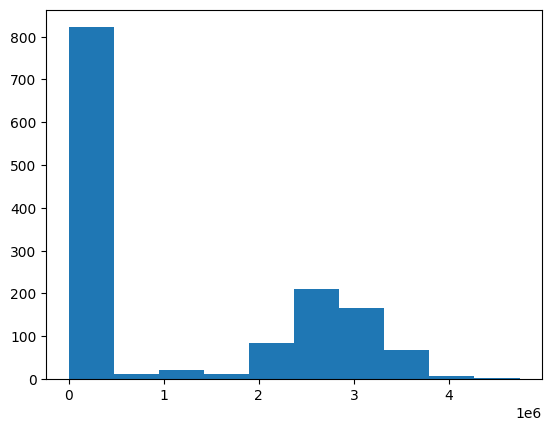

In [123]:
plt.hist(logit_gaussian1_benign)

(array([822.,  13.,  22.,  11.,  85., 210., 167.,  68.,   7.,   3.]),
 array([3.94019170e+01, 4.74310212e+05, 9.48581022e+05, 1.42285183e+06,
        1.89712264e+06, 2.37139345e+06, 2.84566426e+06, 3.31993507e+06,
        3.79420588e+06, 4.26847669e+06, 4.74274750e+06]),
 <BarContainer object of 10 artists>)

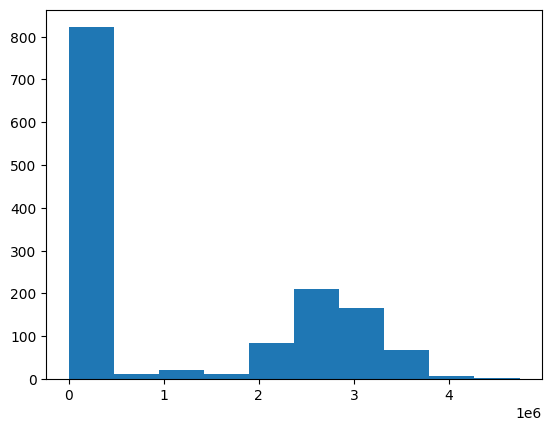

In [124]:
plt.hist(logit_gaussian2_benign)

(array([822.,  13.,  22.,  11.,  85., 210., 167.,  68.,   7.,   3.]),
 array([3.93999940e+01, 4.74310210e+05, 9.48581020e+05, 1.42285183e+06,
        1.89712264e+06, 2.37139345e+06, 2.84566426e+06, 3.31993507e+06,
        3.79420588e+06, 4.26847669e+06, 4.74274750e+06]),
 <BarContainer object of 10 artists>)

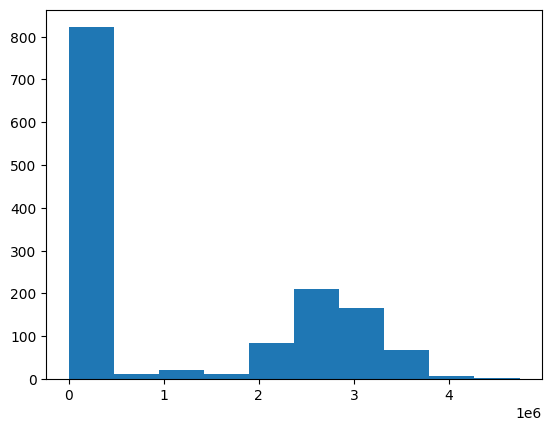

In [125]:
plt.hist(logit_gaussian3_benign)

In [126]:
min(attr_gaussian1_benign), max(attr_gaussian1_benign)

(0.30816805, 0.7783735)

(array([  7.,  37., 116., 262., 351., 315., 198.,  80.,  28.,  14.]),
 array([0.30816805, 0.3551886 , 0.40220914, 0.44922969, 0.49625023,
        0.54327078, 0.59029132, 0.63731187, 0.68433241, 0.73135296,
        0.7783735 ]),
 <BarContainer object of 10 artists>)

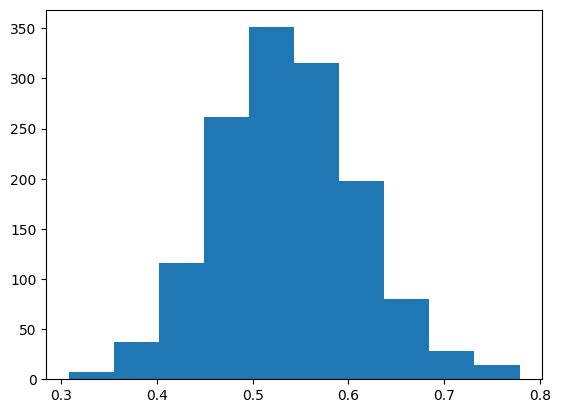

In [127]:
plt.hist(attr_gaussian1_benign)

(array([ 10.,  55., 154., 292., 376., 271., 145.,  72.,  24.,   9.]),
 array([0.32347295, 0.36978038, 0.41608782, 0.46239525, 0.50870269,
        0.55501012, 0.60131756, 0.64762499, 0.69393243, 0.74023986,
        0.7865473 ]),
 <BarContainer object of 10 artists>)

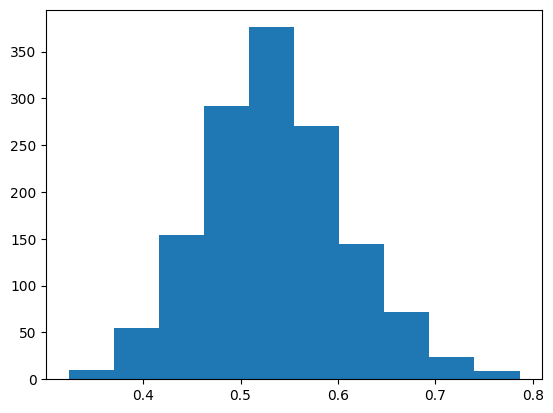

In [128]:
plt.hist(attr_gaussian2_benign)

(array([ 24., 113., 277., 369., 323., 166.,  97.,  26.,   8.,   5.]),
 array([0.3426499 , 0.39183693, 0.44102396, 0.49021099, 0.53939802,
        0.58858505, 0.63777208, 0.68695911, 0.73614614, 0.78533317,
        0.8345202 ]),
 <BarContainer object of 10 artists>)

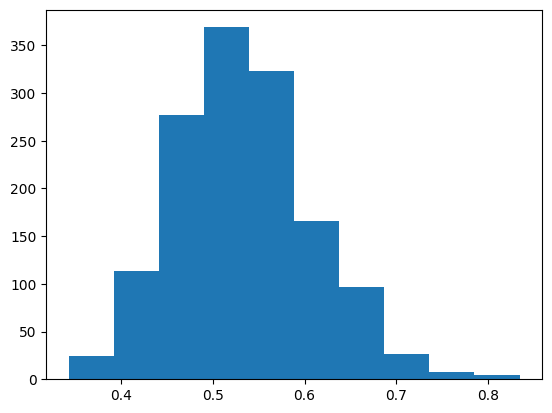

In [129]:
plt.hist(attr_gaussian3_benign)

(array([ 10.,  30., 151., 305., 368., 319., 151.,  51.,  19.,   4.]),
 array([0.30706024, 0.35683335, 0.40660645, 0.45637956, 0.50615266,
        0.55592577, 0.60569888, 0.65547198, 0.70524509, 0.75501819,
        0.8047913 ]),
 <BarContainer object of 10 artists>)

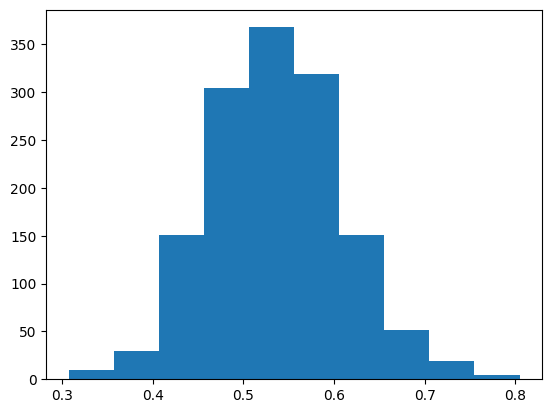

In [130]:
plt.hist(attr_gaussian4_benign)

(array([ 10.,  91., 241., 391., 349., 204.,  87.,  26.,   6.,   3.]),
 array([0.31264138, 0.36795843, 0.42327548, 0.47859254, 0.53390959,
        0.58922664, 0.64454369, 0.69986074, 0.7551778 , 0.81049485,
        0.8658119 ]),
 <BarContainer object of 10 artists>)

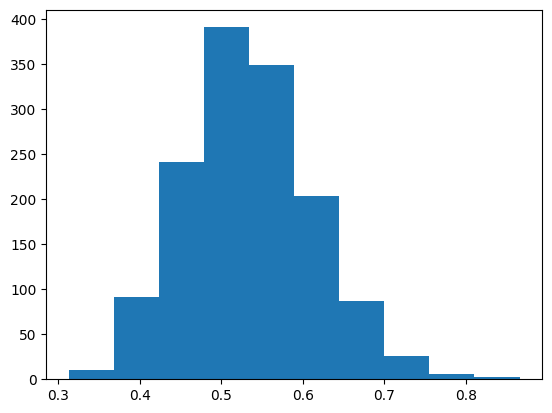

In [131]:
plt.hist(attr_gaussian5_benign)

In [132]:
(0.496382, 6156831.5)

(0.496382, 6156831.5)

In [133]:
(0.28795388, 0.9273894)

(0.28795388, 0.9273894)

In [134]:
t1=[0.4,0.4,0.4]
t2=[100000,300000,400000]
t3=[0.2,0.2,0.2]
t4=[0.93,0.92,0.91]
for x, y,a,b in zip(t1,t2,t3,t4):
    print(compute_fpr(logit_gaussian1_benign, x, y, attr_gaussian1_benign, a,b))
    print("---")

51.77556818181818
---
44.46022727272727
---
41.690340909090914
---


# evaluate detection on adv samples

In [135]:
def compute_metrics_benign(train_loader, normal_model): 
    
    print("Computing metrics for {} for benign")

    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    attribution_gaussian4 = []
    attribution_gaussian5 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    logit_gaussian4 = []
    logit_gaussian5 = []
    
    for step, (x_batch, y_batch) in enumerate(train_loader):
        
        
        images_adv, y_pred_adv = x_batch.to(device), y_batch.to(device)
        x_logits = normal_model(images_adv)
        
        a_batch = quantus.explain(
            model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.0005)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.001)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.005)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        gaussian_noisy_images_4 = make_noise(images_adv, y_pred_adv, spread = 0.01)
        gaussian_logits_4 = normal_model(gaussian_noisy_images_4)
        
        gaussian_noisy_images_5 = make_noise(images_adv, y_pred_adv, spread = 0.1)
        gaussian_logits_5 = normal_model(gaussian_noisy_images_5)
        
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        diff4 = torch.norm(x_logits-gaussian_logits_4,p=1, dim=1) 
        diff5 = torch.norm(x_logits-gaussian_logits_5,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        logit_gaussian4.extend(diff4.detach().cpu().numpy())
        logit_gaussian5.extend(diff5.detach().cpu().numpy())
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian4 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_4, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian5 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_5, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian4):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian4.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian5):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian5.append(c)
        
       
        if step%20==0:
            print(step)
        if step > 20:
            break
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
        attribution_gaussian4,
        attribution_gaussian5,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3,
    logit_gaussian4,
    logit_gaussian5], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution",
        "Gaussian4 attribution",
        "Gaussian5 attribution",
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
        "Gaussian4 logit robusntess",
        "Gaussian5 logit robusntess"
                    ])
            
    path = "kdd_Benign_eval.csv"
    df.to_csv(path)

In [136]:
compute_metrics_benign(test_loader, model)

Computing metrics for {} for benign
0
20


In [137]:
def compute_metrics_adv(train_loader, normal_model): 
    
    print("Computing metrics for {} for benign")

    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    attribution_gaussian4 = []
    attribution_gaussian5 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    logit_gaussian4 = []
    logit_gaussian5 = []
    
    for step, (x_batch, y_batch) in enumerate(train_loader):
        
        
        images_adv, y_pred_adv = x_batch.to(device), y_batch.to(device)
        x_logits = normal_model(images_adv)
        
        a_batch = quantus.explain(
            model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.0005)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.001)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.005)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        gaussian_noisy_images_4 = make_noise(images_adv, y_pred_adv, spread = 0.01)
        gaussian_logits_4 = normal_model(gaussian_noisy_images_4)
        
        gaussian_noisy_images_5 = make_noise(images_adv, y_pred_adv, spread = 0.1)
        gaussian_logits_5 = normal_model(gaussian_noisy_images_5)
        
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        diff4 = torch.norm(x_logits-gaussian_logits_4,p=1, dim=1) 
        diff5 = torch.norm(x_logits-gaussian_logits_5,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        logit_gaussian4.extend(diff4.detach().cpu().numpy())
        logit_gaussian5.extend(diff5.detach().cpu().numpy())
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian4 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_4, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian5 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_5, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian4):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian4.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian5):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian5.append(c)
        
       
        if step%20==0:
            print(step)
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
        attribution_gaussian4,
        attribution_gaussian5,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3,
    logit_gaussian4,
    logit_gaussian5], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution",
        "Gaussian4 attribution",
        "Gaussian5 attribution",
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
        "Gaussian4 logit robusntess",
        "Gaussian5 logit robusntess"
                    ])
            
    path = "kdd_Adv_eval.csv"
    df.to_csv(path)

In [138]:
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_FGSM1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.99, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)

In [139]:
compute_metrics_adv(test_loader_adv, model)

Computing metrics for {} for benign
0


In [140]:
def compute_TPR(adv1, a, b, adv2, c, d): 
    TN=0
    FN=0
    FP = 0 
    TP=0
    
    for value1, value2 in zip(adv1, adv2): 
        if value1<a or value1>b:
            TP += 1
        else:
            if value2<c or value2>d:
                TP+=1
            else: 
                FN+=1
    
    return (TP/(TP+FN))*100

In [141]:
def compute_FPR(ap2a, k, l, ap2b, m, n): 
    TN=0
    FN=0
    FP=0 
    TP=0
    
    for value6, value7 in zip(ap2a,ap2b):
        if value6<k or value6>l:
            FP +=1
        else:
            if value7<m or value7>n:
                FP +=1

    return (FP/(len(ap2a)))*100

In [175]:
k=[0.4,0.4,0.4, 0.4, 0.4, 0.4,0.4,0.4,0.4,0.4,0.4, 0.4, 0.4, 0.4]
l=[3000000,2500000,2000000,1000000, 800000, 700000,600000,500000,400000,300000,100000,80000, 60000, 40000]
m=[0.2,0.2,0.2, 0.2, 0.2, 0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,]
n=[1.2, 1.1,1.0, 0.95, 0.94, 0.93,0.92,0.91,0.85,0.80,0.70, 0.60, 0.50, 0.40, 0.30]

In [181]:
score = []
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)

df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)

s = sklearn.metrics.auc(fpr_results, tpr_results)
score.append(s)

1408 1408
200 200


In [182]:
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_FGSM2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [183]:
np.mean(score), np.std(score)

(0.8797052556818181, 0.0017365056818182123)

In [184]:
# Load CSV file and split into train and test sets
score = []
advdataset = CustomDataset('adversarial_examples_autoPGD.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [185]:
advdataset = CustomDataset('adversarial_examples_autoPGD2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [186]:
np.mean(score), np.std(score)

(0.8830131392045455, 0.0020614346590909216)

In [187]:
# Load CSV file and split into train and test sets
score = []
advdataset = CustomDataset('adversarial_examples_BIM1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [188]:
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_BIM2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [189]:
np.mean(score), np.std(score)

(0.8768821022727273, 0.00034446022727269154)

In [190]:
# Load CSV file and split into train and test sets
score = [] 

advdataset = CustomDataset('adversarial_examples_PGD1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [191]:
advdataset = CustomDataset('adversarial_examples_PGD2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [192]:
np.mean(score), np.std(score)

(0.8797594105113637, 0.0016184303977272996)

In [193]:
score = [] 
advdataset = CustomDataset('adversarial_examples_CW1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [194]:
score = [] 
advdataset = CustomDataset('adversarial_examples_CW2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("kdd_Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("kdd_Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [195]:
np.mean(score), np.std(score)

(0.8807421875, 0.0)